# LQI-Induced Rating Prediction from Text Reviews
This notebook implements the approach described in the research paper:
**Estimating numerical scale ratings from text-based service reviews**.

We'll use sentiment analysis and a simple machine learning model to predict Likert-scale ratings based on review text.

In [24]:
# Import required packages
import json
import pandas as pd
from afinn import Afinn
from nltk.tokenize import sent_tokenize
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# necessary tokenizer
import nltk
nltk.download('punkt')

# Initialize sentiment analyzer
afinn = Afinn()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
lqi_dict = {
    "Tangibility": ["appearance", "desk", "touch", "facility"],
    "Reliability": ["accurate", "reliable", "trust", "prompt"],
    "Assurance": ["knowledgeable", "confidence", "secure"],
    "Empathy": ["friendly", "helpful", "attention", "understanding"]
}

In [26]:
def analyze_review(review):
    result = {dim: [] for dim in lqi_dict}
    sentences = sent_tokenize(review.lower())

    for sent in sentences:
        score = afinn.score(sent)
        for dim, keywords in lqi_dict.items():
            if any(word in sent for word in keywords):
                result[dim].append(score)

    result = {dim: (sum(scores)/len(scores) if scores else None) for dim, scores in result.items()}
    return result

In [ ]:
import nltk
nltk.download('punkt_tab')

sample_review = "The front desk was extremely nice. The room was clean and the staff were very helpful."
analyze_review(sample_review)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


{'Tangibility': None, 'Reliability': None, 'Assurance': None, 'Empathy': None}

In [28]:
data = {
    'review_text': [
        'Great room and very clean. The front desk was helpful.',
        'Staff was rude and the bed was uncomfortable.',
        'Loved the facility, but the service could be more prompt.',
        'Friendly and welcoming team at the reception.',
        'Not very secure, felt ignored by the staff.'
    ],
    'tangibility_score': [6, 2, 5, 4, 2],
    'reliability_score': [5, 1, 3, 4, 1],
    'assurance_score': [6, 2, 4, 5, 1],
    'empathy_score': [5, 1, 3, 6, 1]
}
df = pd.DataFrame(data)
df

,review_text,tangibility_score,reliability_score,assurance_score,empathy_score
0,Great room and very clean. The front desk was ...,6,5,6,5
1,Staff was rude and the bed was uncomfortable.,2,1,2,1
2,"Loved the facility, but the service could be m...",5,3,4,3
3,Friendly and welcoming team at the reception.,4,4,5,6
4,"Not very secure, felt ignored by the staff.",2,1,1,1


In [29]:
analyzed = df['review_text'].apply(analyze_review).apply(pd.Series)
df = pd.concat([df, analyzed], axis=1)
df

,review_text,tangibility_score,reliability_score,assurance_score,empathy_score,Tangibility,Reliability,Assurance,Empathy
0,Great room and very clean. The front desk was ...,6,5,6,5,2.0,NaN,NaN,2.0
1,Staff was rude and the bed was uncomfortable.,2,1,2,1,NaN,NaN,NaN,NaN
2,"Loved the facility, but the service could be m...",5,3,4,3,3.0,3.0,NaN,NaN
3,Friendly and welcoming team at the reception.,4,4,5,6,NaN,NaN,NaN,2.0
4,"Not very secure, felt ignored by the staff.",2,1,1,1,NaN,NaN,0.0,NaN


In [30]:
X = df[['Tangibility', 'Reliability', 'Assurance', 'Empathy']].fillna(0)
y = df['tangibility_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))

MSE: 3.5716337987487826e-09


In [31]:
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

In [33]:
comparison

,Actual,Predicted
0,2,2.00006


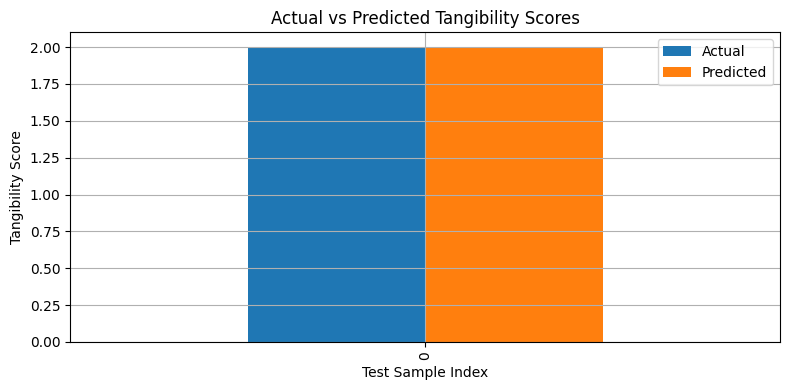

In [34]:
comparison.plot(kind='bar', title='Actual vs Predicted Tangibility Scores', figsize=(8, 4), legend=True)
plt.xlabel("Test Sample Index")
plt.ylabel("Tangibility Score")
plt.grid(True)
plt.tight_layout()
plt.show()